In [1]:
#fetch the require libraries 

import numpy as np
import pandas as pd
import datetime
from datetime import date
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

In [2]:
#import the data
msdf = pd.read_csv('marketing_campaign.csv')

In [3]:
msdf.shape

(2240, 29)

In [4]:
msdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Finding:
    
1.we have 3 object types- in which one is a datetime which we will convert it into one
2.remaining we have integer type
3.we can drop the id column

In [5]:

msdf.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [6]:
unique = [feature for feature in msdf.columns if len(msdf[feature].unique())>0 and len(msdf[feature].unique())<100]
for feature in unique:
  print("{} has {} unique values : {} {}".format(feature,len(msdf[feature].unique()),msdf[feature].unique(),"\n"))

Year_Birth has 59 unique values : [1957 1954 1965 1984 1981 1967 1971 1985 1974 1950 1983 1976 1959 1952
 1987 1946 1980 1949 1982 1979 1951 1969 1986 1989 1963 1970 1973 1943
 1975 1996 1968 1964 1977 1978 1955 1966 1988 1948 1958 1972 1960 1945
 1991 1962 1953 1961 1956 1992 1900 1893 1990 1947 1899 1993 1994 1941
 1944 1995 1940] 

Education has 5 unique values : ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle'] 

Marital_Status has 8 unique values : ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO'] 

Kidhome has 3 unique values : [0 1 2] 

Teenhome has 3 unique values : [0 1 2] 

NumDealsPurchases has 15 unique values : [ 3  2  1  5  4 15  7  0  6  9 12  8 10 13 11] 

NumWebPurchases has 15 unique values : [ 8  1  2  5  6  7  4  3 11  0 27 10  9 23 25] 

NumCatalogPurchases has 14 unique values : [10  1  2  0  3  4  6 28  9  5  8  7 11 22] 

NumStorePurchases has 14 unique values : [ 4  2 10  6  7  0  3  8  5 12  9 13 11  1] 

NumWebVisitsMonth has 16 unique

In [7]:
#conveting all column to lower case 
msdf.columns = msdf.columns.str.lower()

In [8]:
#checking missing values

total = msdf.isnull().sum().sort_values(ascending=False)
percent = (msdf.isnull().sum()/ msdf.isnull().count()*100)
missing = pd.concat([total,percent],axis =1,keys=['total','percent'])
missing.head()

,total,percent
income,24,1.071429
id,0,0.000000
numdealspurchases,0,0.000000
z_revenue,0,0.000000
z_costcontact,0,0.000000


since we only have 24 missing data points we can drop it since it wont much impact on our model

In [9]:
msdf = msdf.dropna()
print("we have {} missing values".format(msdf.isnull().sum().sum()))

we have 0 missing values


In [10]:
#numerical features 

numerical_features = [feature for feature in msdf.columns if msdf[feature].dtype != "O"]
print("we have {} numerical features out of {}".format(len(numerical_features),len(msdf.columns)))

we have 26 numerical features out of 29


In [11]:
#checking discrete variable

discrete_features = [feature for feature in numerical_features if len(msdf[feature].unique())<25]
print("we have {} discrete features out of {} total features".format(len(discrete_features),len(msdf.columns)))

we have 16 discrete features out of 29 total features


In [12]:
msdf[discrete_features].head()

,kidhome,teenhome,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,z_costcontact,z_revenue,response
0,0,0,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,1,1,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,0,0,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,1,0,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,1,0,5,5,3,6,5,0,0,0,0,0,0,3,11,0


findings:
    
    instead of having two features for kids and teen we can have 1 feature which will be total number of kids
similary we can combine all the purchases into one features
same goes with whether accepted or not

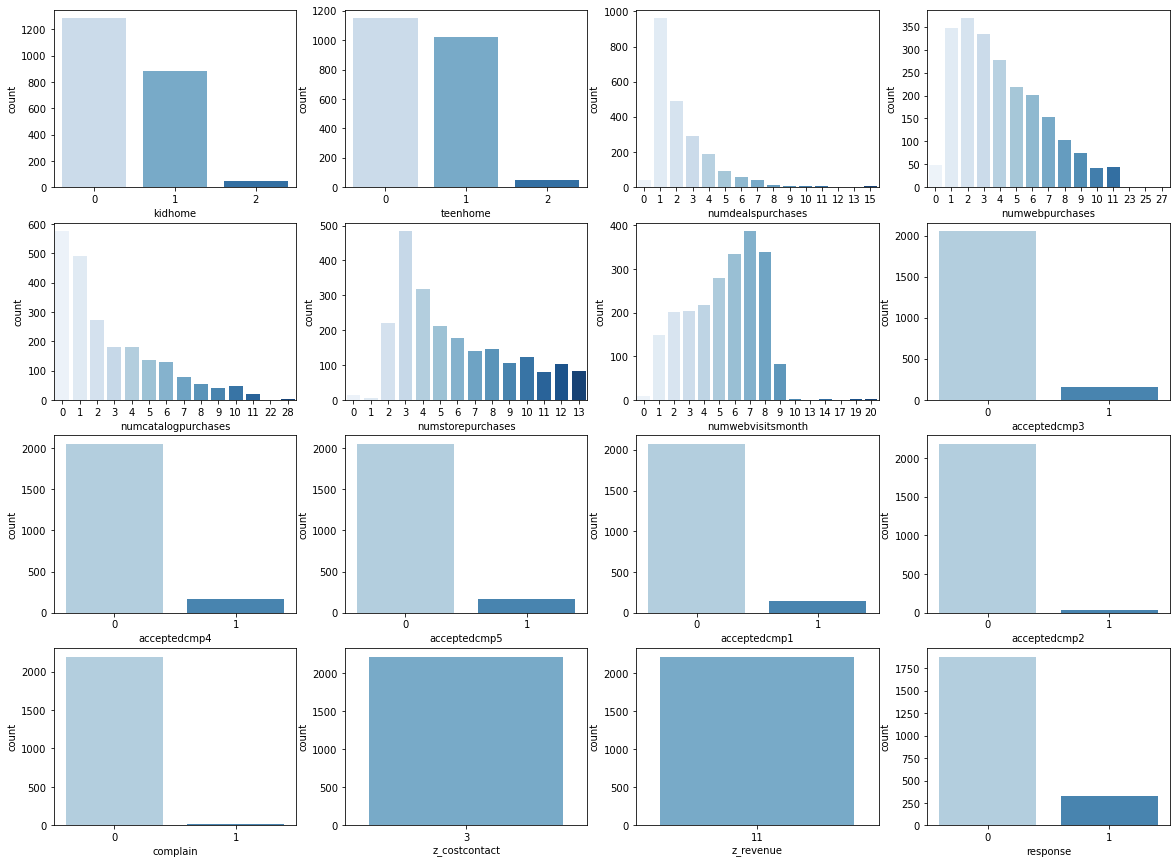

In [13]:
#univariate analysis 

fig,ax = plt.subplots(4,4,figsize=(20,15))
for variable, subplot in zip(discrete_features,ax.flatten()):
  sns.countplot(msdf[variable],ax=subplot,palette= "Blues")

findings:
    
1.most people either has no kids or has atleast one child
2.most people purchased atleast one product via web and has the purchases increases the count decreases,which is understandable since the data is only till 2014
3.people who did not purchased with the catalog as the reference are the highest
4.most people bought via a store
5.coming to campaign there is not much of a difference in each campaign,so we can also drop them or combine them
6.majority did not had a single complaint
7.people who did not responded are the highest

In [14]:
# this will combine both the kids into a single columns kids
msdf['total_kids'] = msdf['kidhome']+msdf['teenhome']


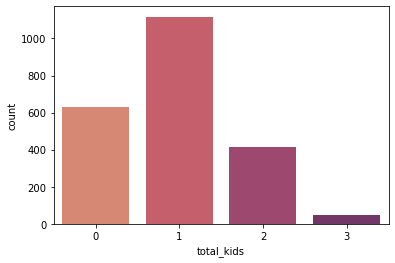

In [15]:
sns.countplot(msdf['total_kids'],palette='flare');

findings:
    
    when we combine both teen and kid into one we can see that most people have atleast one child
let us create a new feature for total_Accepted and total_purchase since as we can see there is not a huge difference between each so we are better off having a single feature rather than a bunch of em

In [16]:
msdf['total_accep'] = msdf['acceptedcmp1'] + msdf['acceptedcmp2']+msdf['acceptedcmp3'] + msdf['acceptedcmp4']	+msdf['acceptedcmp5']	+msdf['response']

msdf['total_purchase'] = msdf['numdealspurchases']+msdf['numwebpurchases']+msdf['numcatalogpurchases']+msdf['numstorepurchases']

let us drop all the irrelevant features

In [17]:
msdf.drop(['kidhome','teenhome','numdealspurchases','numwebpurchases','numcatalogpurchases','numstorepurchases','numwebvisitsmonth','acceptedcmp3',
         'acceptedcmp4','acceptedcmp5','acceptedcmp1','acceptedcmp2','complain','z_costcontact','z_revenue','response'],axis=1,inplace=True)

In [18]:
msdf.head()

,id,year_birth,education,marital_status,income,dt_customer,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,total_kids,total_accep,total_purchase
0,5524,1957,Graduation,Single,58138.0,2012-09-04,58,635,88,546,172,88,88,0,1,25
1,2174,1954,Graduation,Single,46344.0,2014-03-08,38,11,1,6,2,1,6,2,0,6
2,4141,1965,Graduation,Together,71613.0,2013-08-21,26,426,49,127,111,21,42,0,0,21
3,6182,1984,Graduation,Together,26646.0,2014-02-10,26,11,4,20,10,3,5,1,0,8
4,5324,1981,PhD,Married,58293.0,2014-01-19,94,173,43,118,46,27,15,1,0,19


In [19]:
#continous varibale 

continuos_features = [feature for feature in numerical_features if feature not in discrete_features]
print("we have {} continuos features out of {} total features".format(len(continuos_features),len(msdf.columns)))

we have 10 continuos features out of 16 total features


In [20]:
#checking head counts for continous varibale 

msdf[continuos_features].head()

,id,year_birth,income,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods
0,5524,1957,58138.0,58,635,88,546,172,88,88
1,2174,1954,46344.0,38,11,1,6,2,1,6
2,4141,1965,71613.0,26,426,49,127,111,21,42
3,6182,1984,26646.0,26,11,4,20,10,3,5
4,5324,1981,58293.0,94,173,43,118,46,27,15


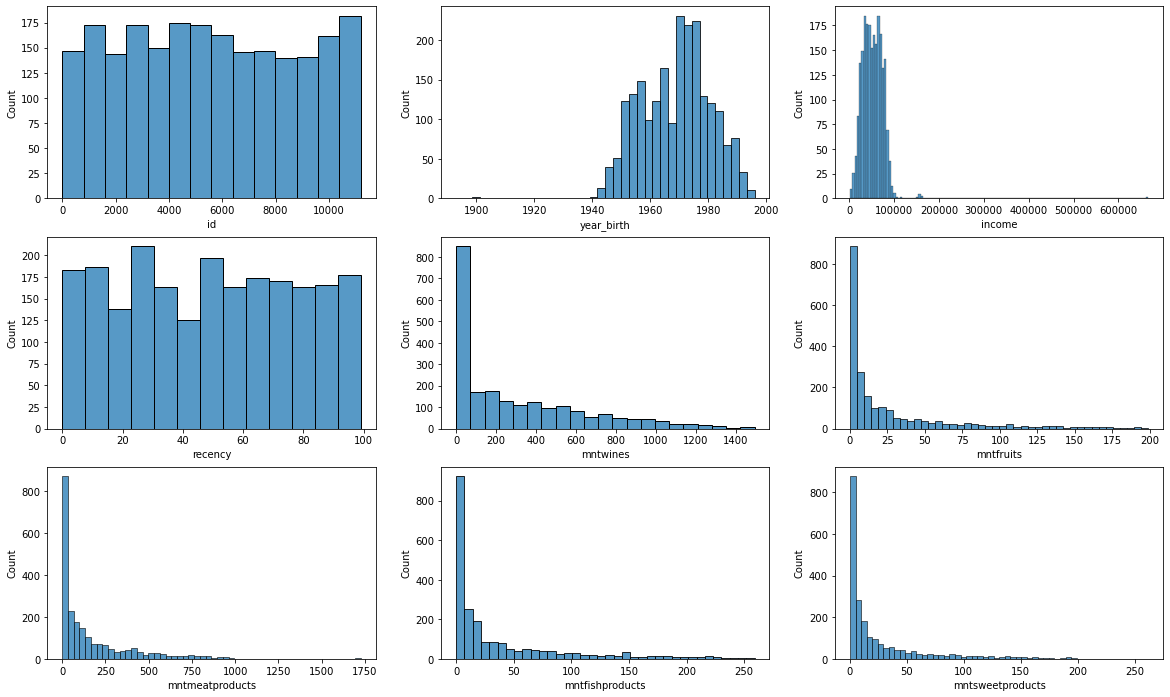

In [21]:
fig,ax = plt.subplots(3,3,figsize=(20,12))
for variable, subplot in zip(continuos_features,ax.flatten()):
  sns.histplot(msdf[variable],ax=subplot)

Findings:
    
1. year and income has outliers in it
2. 30 days seems to be the longest time since the customers last purchase
3. instead of having so many columns on amount spent we can combine all the features into one feature which will have the total spending of a customer
4. we can also create a new age feature which will be easier to remove outliers

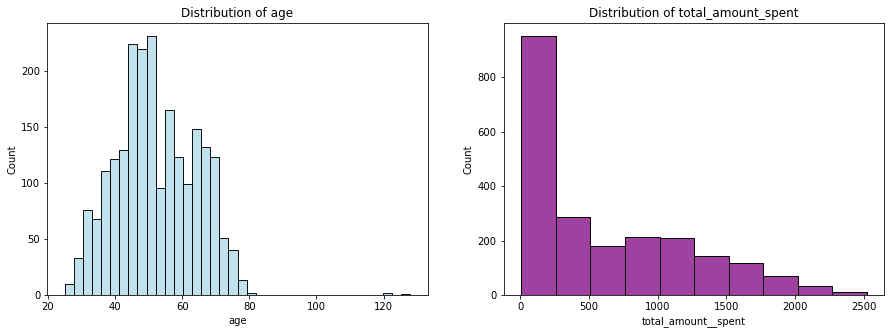

In [22]:
msdf['age'] = 2021 -msdf['year_birth']
msdf['total_amount__spent']= msdf['mntwines'] + msdf['mntfruits'] +msdf['mntmeatproducts'] +msdf["mntfishproducts"] +msdf['mntsweetproducts']+msdf['mntgoldprods']
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.histplot(msdf['age'],color='lightblue')
plt.title('Distribution of age')

plt.subplot(1,2,2)
sns.histplot(msdf['total_amount__spent'],color='purple',bins=10)
plt.title('Distribution of total_amount_spent');

In [23]:
#dropping non require features

msdf.drop(['mntwines','mntfruits','mntmeatproducts','mntfishproducts','mntsweetproducts','mntgoldprods'],axis=1,inplace=True)

In [24]:
msdf.head()

,id,year_birth,education,marital_status,income,dt_customer,recency,total_kids,total_accep,total_purchase,age,total_amount__spent
0,5524,1957,Graduation,Single,58138.0,2012-09-04,58,0,1,25,64,1617
1,2174,1954,Graduation,Single,46344.0,2014-03-08,38,2,0,6,67,27
2,4141,1965,Graduation,Together,71613.0,2013-08-21,26,0,0,21,56,776
3,6182,1984,Graduation,Together,26646.0,2014-02-10,26,1,0,8,37,53
4,5324,1981,PhD,Married,58293.0,2014-01-19,94,1,0,19,40,422


In [25]:
#checking to catagorical varibale

categorical_features = [feature for feature in msdf.columns if msdf[feature].dtype == "O"]
print("we have {} continuos features out of {} features".format(len(categorical_features),len(msdf.columns)))

we have 3 continuos features out of 12 features


In [26]:
msdf[categorical_features].head()

,education,marital_status,dt_customer
0,Graduation,Single,2012-09-04
1,Graduation,Single,2014-03-08
2,Graduation,Together,2013-08-21
3,Graduation,Together,2014-02-10
4,PhD,Married,2014-01-19


In [27]:
#converting the date and time

msdf["dt_customer"] = pd.to_datetime(msdf["dt_customer"]).dt.date
print("The newest date is:",max(msdf["dt_customer"]))
print("The oldest date is:",min(msdf["dt_customer"]))

The newest date is: 2014-06-29
The oldest date is: 2012-07-30


In [28]:
msdf.dt_customer.dtype

dtype('O')

In [29]:
#creating a function which will show how many days has it been since the customer started shopping

from datetime import date
days = []
d1 = max(msdf['dt_customer'])
for i in msdf['dt_customer']:
    delta = d1 - i
    days.append(delta.days)
msdf["total_days"] = days
msdf["total_days"] = pd.to_numeric(msdf["total_days"], errors="coerce")

In [30]:
print("education      :",msdf.education.unique())
print("marital_status :",msdf.marital_status.unique())

education      : ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
marital_status : ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


In [31]:
#for education & marriage 

msdf['marital_status'] = msdf['marital_status'].replace({"Together":"Married", "Absurd":"Single", "Widow":"Single", "YOLO":"Single", "Divorced":"Single", "Alone":"Single",})

msdf['education'] = msdf['education'].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

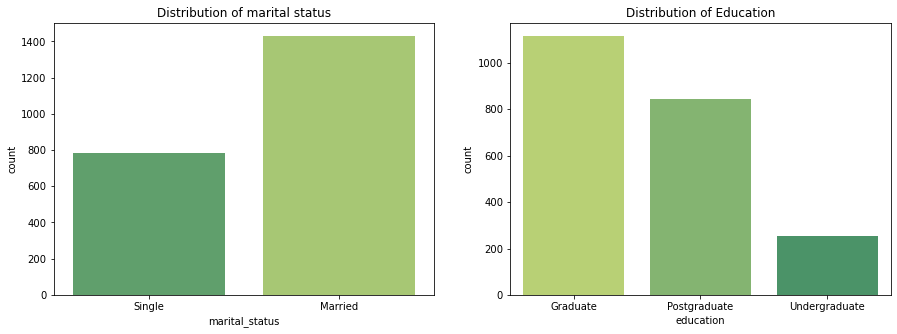

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(msdf['marital_status'],palette ='summer')
plt.title('Distribution of marital status')

plt.subplot(1,2,2)
sns.countplot(msdf['education'],palette ='summer_r')
plt.title('Distribution of Education');

Findings:
    
1.most people are married in our dataset
2.most peoples are graduates in our dataset

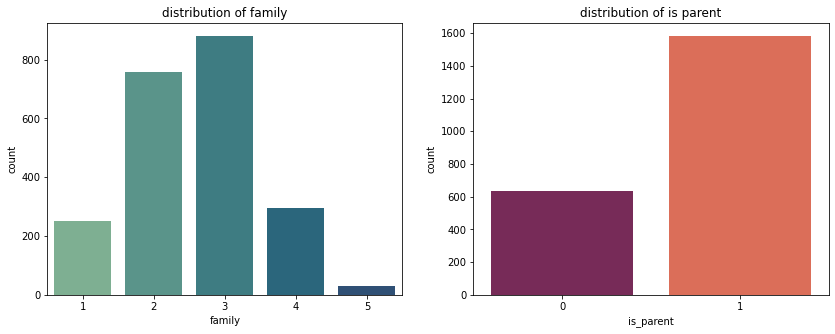

In [33]:
msdf['family'] = msdf['marital_status'].replace({'Single':1,"Married":2}) + msdf['total_kids']
# we will create a new column which will contain all the total members in an household

msdf['is_parent'] = np.where(msdf.total_kids>0,1,0)
# this feature will choose 1 if a family has a parent in it else 0

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(msdf['family'],palette='crest')
plt.title('distribution of family')

plt.subplot(1,2,2)
sns.countplot(msdf['is_parent'],palette='rocket')
plt.title('distribution of is parent');

findings:
    
1. as we can see most people in an household are a parent
2. most family has atleast 2 and 3 members in it

In [34]:
#deleting several feature which are not require 

msdf.drop(['year_birth','dt_customer','recency',],axis=1,inplace=True)

In [35]:
msdf.head()

,id,education,marital_status,income,total_kids,total_accep,total_purchase,age,total_amount__spent,total_days,family,is_parent
0,5524,Graduate,Single,58138.0,0,1,25,64,1617,663,1,0
1,2174,Graduate,Single,46344.0,2,0,6,67,27,113,3,1
2,4141,Graduate,Married,71613.0,0,0,21,56,776,312,2,0
3,6182,Graduate,Married,26646.0,1,0,8,37,53,139,3,1
4,5324,Postgraduate,Married,58293.0,1,0,19,40,422,161,3,1


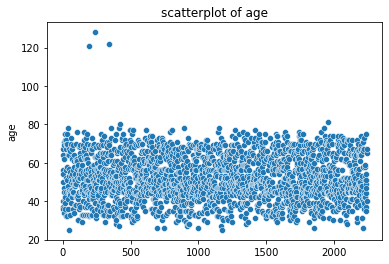

In [36]:
#checking outliers 

sns.scatterplot(data =msdf['age'])
plt.title('scatterplot of age');

In [37]:
msdf[msdf['age']>90]

,id,education,marital_status,income,total_kids,total_accep,total_purchase,age,total_amount__spent,total_days,family,is_parent
192,7829,Undergraduate,Single,36640.0,1,0,6,121,65,276,2,1
239,11004,Undergraduate,Single,60182.0,1,0,4,128,22,43,2,1
339,1150,Postgraduate,Married,83532.0,0,1,15,122,1853,276,2,0


as in the data there are three data-points above 90, therefore we can drop them

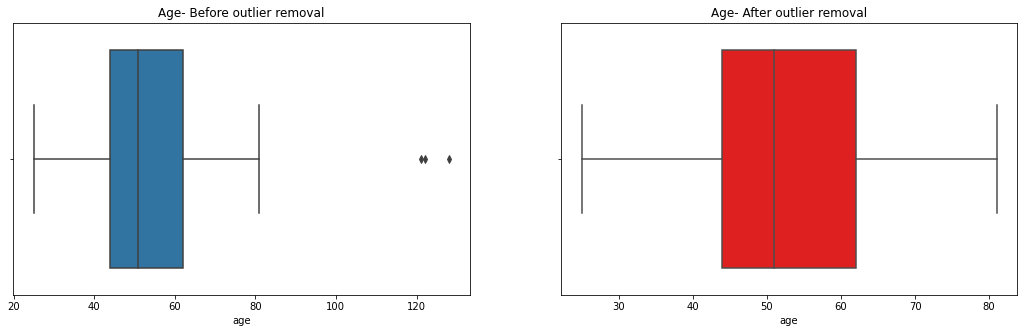

In [38]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
sns.boxplot(msdf['age'])
plt.title("Age- Before outlier removal");

msdf = msdf.drop(msdf[msdf['age']>90].index)  # to remove the outliers

plt.subplot(1,2,2)
sns.boxplot(msdf['age'],color='r')
plt.title('Age- After outlier removal');

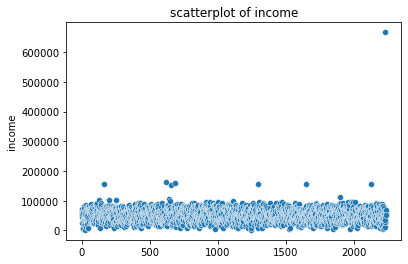

In [39]:
#checking again the scatter plot 

sns.scatterplot(data = msdf['income'])
plt.title('scatterplot of income');

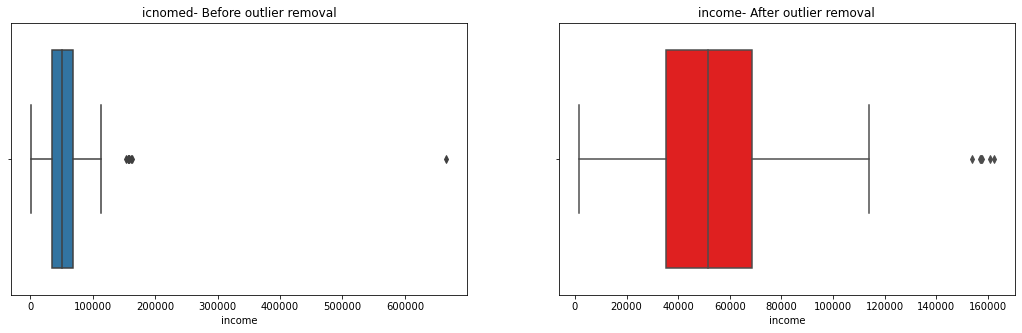

In [40]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
sns.boxplot(msdf['income'])
plt.title("icnomed- Before outlier removal");

msdf = msdf.drop(msdf[msdf['income']>600000].index)  # to remove the outliers

plt.subplot(1,2,2)
sns.boxplot(msdf['income'],color='r')
plt.title('income- After outlier removal');

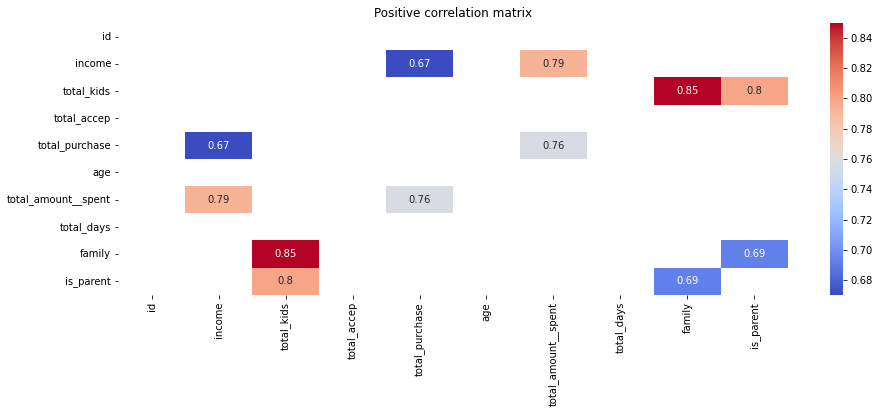

In [41]:
#checking the co-relation among the remaing important attributes 

pos_corrmat = msdf.corr()
filtereddf = pos_corrmat[((pos_corrmat >= .5) & (pos_corrmat !=1.000))]
plt.figure(figsize=(15,5))
sns.heatmap(filtereddf, annot=True, cmap="coolwarm")
plt.title('Positive correlation matrix')
plt.show()

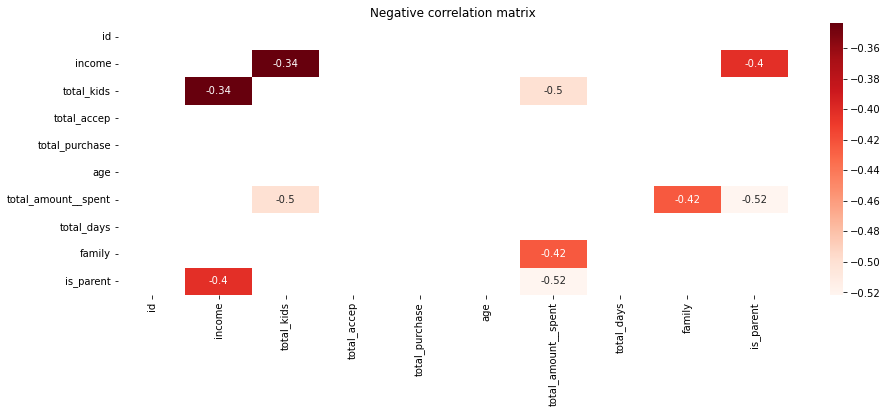

In [42]:
#checking -ve co-relation among attributes 

neg_corrmat = msdf.corr()
filtereddf = neg_corrmat[((neg_corrmat <-.3) & (neg_corrmat !=1.000))]
plt.figure(figsize=(15,5))
sns.heatmap(filtereddf, annot=True, cmap="Reds")
plt.title('Negative correlation matrix')
plt.show()

In [43]:
object_feat = [feature for feature in msdf.columns if msdf[feature].dtype == "O"]
msdf[object_feat].head()

,education,marital_status
0,Graduate,Single
1,Graduate,Single
2,Graduate,Married
3,Graduate,Married
4,Postgraduate,Married


In [44]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in object_feat:
  msdf[i] = msdf[[i]].apply(le.fit_transform)

In [45]:
msdf.head()

,id,education,marital_status,income,total_kids,total_accep,total_purchase,age,total_amount__spent,total_days,family,is_parent
0,5524,0,1,58138.0,0,1,25,64,1617,663,1,0
1,2174,0,1,46344.0,2,0,6,67,27,113,3,1
2,4141,0,0,71613.0,0,0,21,56,776,312,2,0
3,6182,0,0,26646.0,1,0,8,37,53,139,3,1
4,5324,1,0,58293.0,1,0,19,40,422,161,3,1


important points:
    
    
standardizing makes the mean 0 and variance as 1 which in turn makes all the data consistent throughout
Standardized data takes less computational power than non-standardized one
It reduces the bias if present in the dataset.
it is not mandatory that we must always scale the data but since we are working on clustering where distance between the datapoints are considered it is better to standardize the data.

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
df2 = scaler.fit_transform(msdf)

In [47]:
df2 = pd.DataFrame(df2,columns = msdf.columns)
# converting the transformed data into dataframe
df2.head()

,id,education,marital_status,income,total_kids,total_accep,total_purchase,age,total_amount__spent,total_days,family,is_parent
0,-0.018837,-0.893586,1.349603,0.287105,-1.264598,0.617244,1.317945,1.018352,1.676245,1.527721,-1.758359,-1.581139
1,-1.050626,-0.893586,1.349603,-0.260882,1.404572,-0.502808,-1.159273,1.274785,-0.963297,-1.189011,0.449070,0.632456
2,-0.444797,-0.893586,-0.740959,0.913196,-1.264598,-0.502808,0.796425,0.334530,0.280110,-0.206048,-0.654644,-1.581139
3,0.183824,-0.893586,-0.740959,-1.176114,0.069987,-0.502808,-0.898513,-1.289547,-0.920135,-1.060584,0.449070,0.632456
4,-0.080437,0.571657,-0.740959,0.294307,0.069987,-0.502808,0.535666,-1.033114,-0.307562,-0.951915,0.449070,0.632456


In [53]:
#checking with cluster 


scaled_df= df2.copy()



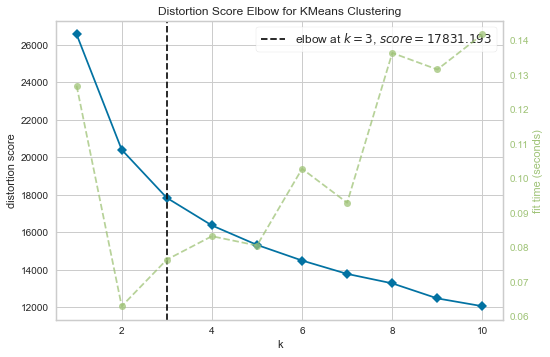

In [54]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(scaled_df)
visualizer.show();

In [55]:
#model building now 

kmeans = KMeans(n_clusters=3,init='k-means++',random_state=0)
pred_kmeans = kmeans.fit_predict(scaled_df)

In [57]:
msdf['pred_kmeans'] = pred_kmeans+1
msdf.head()

,id,education,marital_status,income,total_kids,total_accep,total_purchase,age,total_amount__spent,total_days,family,is_parent,pred_kmeans
0,5524,0,1,58138.0,0,1,25,64,1617,663,1,0,1
1,2174,0,1,46344.0,2,0,6,67,27,113,3,1,3
2,4141,0,0,71613.0,0,0,21,56,776,312,2,0,1
3,6182,0,0,26646.0,1,0,8,37,53,139,3,1,3
4,5324,1,0,58293.0,1,0,19,40,422,161,3,1,2


In [58]:
#analyzing the new dataframe 

personal = msdf[['education','marital_status','total_kids','total_accep','family','is_parent']]

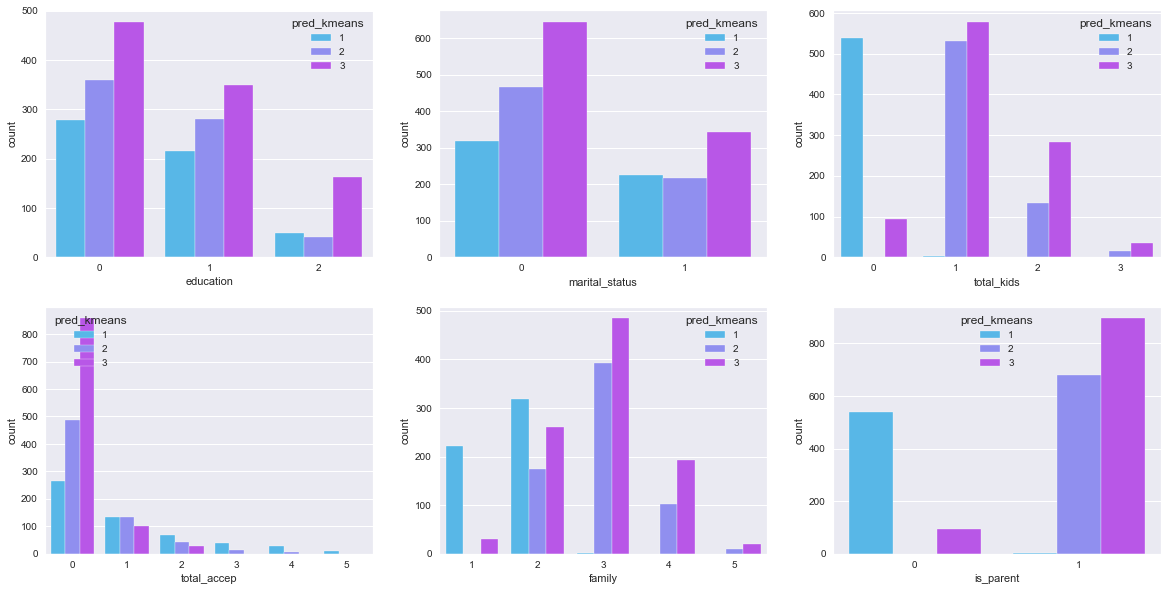

In [61]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
sns.set_style('darkgrid')
for variable, subplot in zip(personal,ax.flatten()):
  sns.countplot(msdf[variable],hue=msdf['pred_kmeans'],ax=subplot,palette='cool')

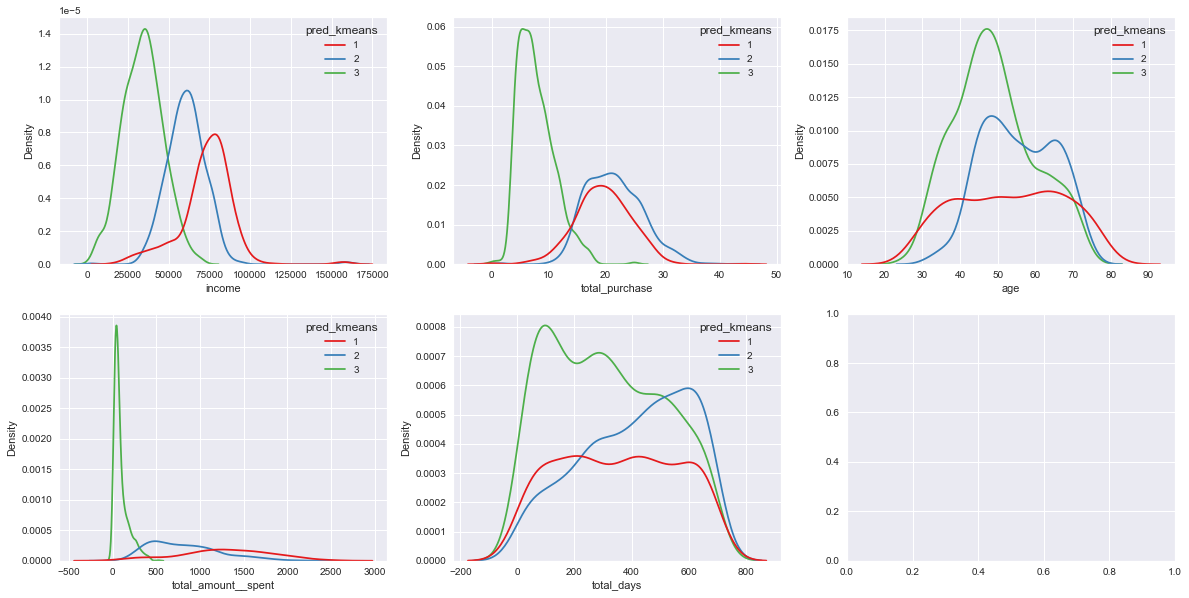

In [63]:
other = msdf[['income','total_purchase','age','total_amount__spent','total_days']]

fig,ax = plt.subplots(2,3,figsize=(20,10))
sns.set_style('darkgrid')
for variable, subplot in zip(other,ax.flatten()):
  sns.kdeplot(data= msdf,x=variable,hue='pred_kmeans',ax=subplot,palette='Set1')

Findings in cluster 1:
    - most customers are graduates
- most customers are married,ratio
is around 100:50
- has atleast 1 kid
- accepted the offer on 1st campaign
- most customers have a family of 3
- high majority of customers are
parents
- less income compared to other
clusters
- purchases are less compared to
other clusters
- age is between 25 and 80
-spending is less
- have been the most loyal
customers, engagement with the
firm is the highest

findings in cluster 2:
    
    most customers are graduates
- ratio of married is slightly
higher than single
- most customers has no child
- most accepted the offer on 1st
campaign
- most of them are a, family of 2
- They are definitely not a parent
- average income greater than
cluster 1 but less than cluster 3
- high purchases compared to,
other clusters
- age is between 30 and 80
- average spending is around 300
and 900
- most customers have been
highly engaged with firm only a
bit lesser than cluster 1

findings in cluster 3 :
    
    - most customer are graduates
- most customers are
married,ratio is around 100:50
- most customers has only a
single child
- most accepted the offer on 1st
campaign
- most of them are a family of 3
- They are definitely a parent
- Has the highest income
- second highest purchasing
power
- age is between 20 and 90
- highest spending amongst all 3
clusters
- least engaged with firm
amongst the 3

In [64]:
new_df = df2.copy()

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(new_df)
PCA_df = pd.DataFrame(pca.transform(new_df), columns=(["col1","col2", "col3"]))
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,1.325040e-17,1.962174,-3.907740,-1.608043,-0.335972,1.278460,5.378042
col2,2212.0,-7.086957e-17,1.326984,-4.225441,-0.844563,0.043824,0.909252,4.418548
col3,2212.0,2.805672e-17,1.053438,-2.657689,-0.792875,-0.152464,0.789522,2.684655


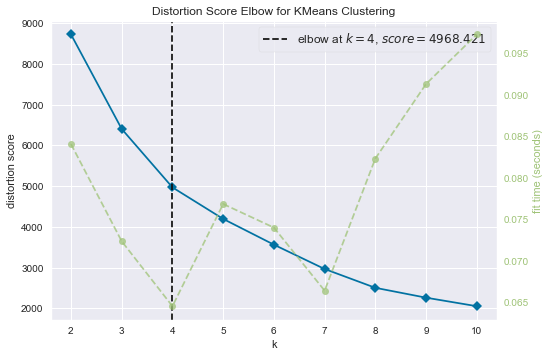

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [66]:
from yellowbrick.cluster import KElbowVisualizer
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_df)
Elbow_M.show()

In [67]:
from sklearn.cluster import AgglomerativeClustering
model_agg = AgglomerativeClustering(n_clusters=4)
pred_agg = model_agg.fit_predict(new_df)

In [69]:
msdf['pred_agg'] = pred_agg+1
msdf.drop('pred_kmeans',axis=1,inplace=True)
msdf.head()

,id,education,marital_status,income,total_kids,total_accep,total_purchase,age,total_amount__spent,total_days,family,is_parent,pred_agg
0,5524,0,1,58138.0,0,1,25,64,1617,663,1,0,1
1,2174,0,1,46344.0,2,0,6,67,27,113,3,1,3
2,4141,0,0,71613.0,0,0,21,56,776,312,2,0,1
3,6182,0,0,26646.0,1,0,8,37,53,139,3,1,2
4,5324,1,0,58293.0,1,0,19,40,422,161,3,1,4


In [70]:
personal_feat = msdf[['education','marital_status','total_kids','family','is_parent']]
other_feat = msdf[['income','age','total_amount__spent','total_days']]

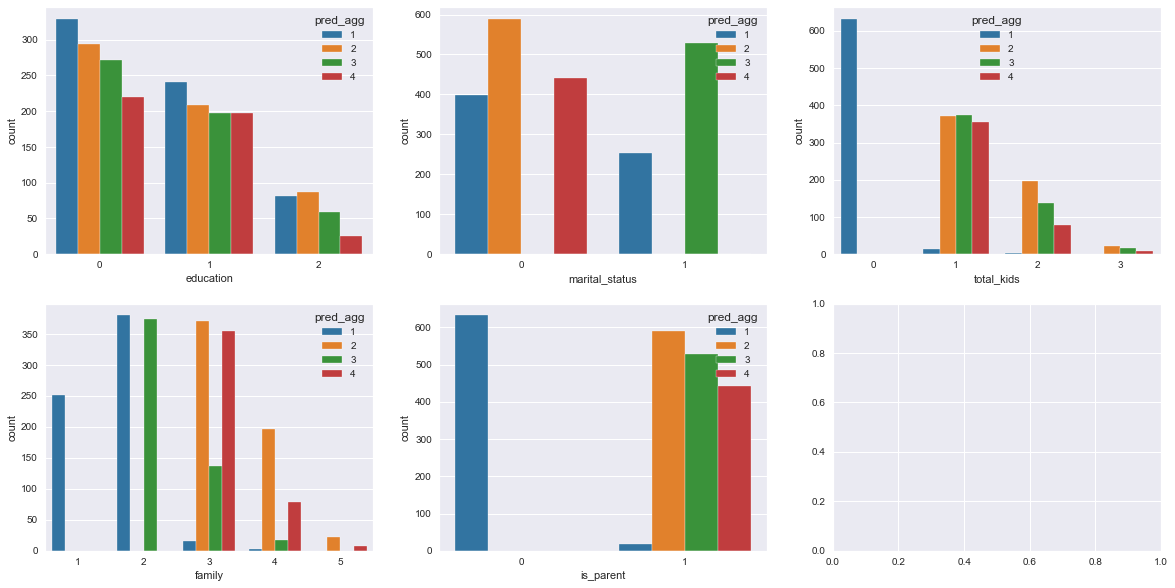

In [72]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
sns.set_style('darkgrid')
for variable, subplot in zip(personal_feat,ax.flatten()):
  sns.countplot(msdf[variable],hue=msdf['pred_agg'],ax=subplot,palette='tab10')


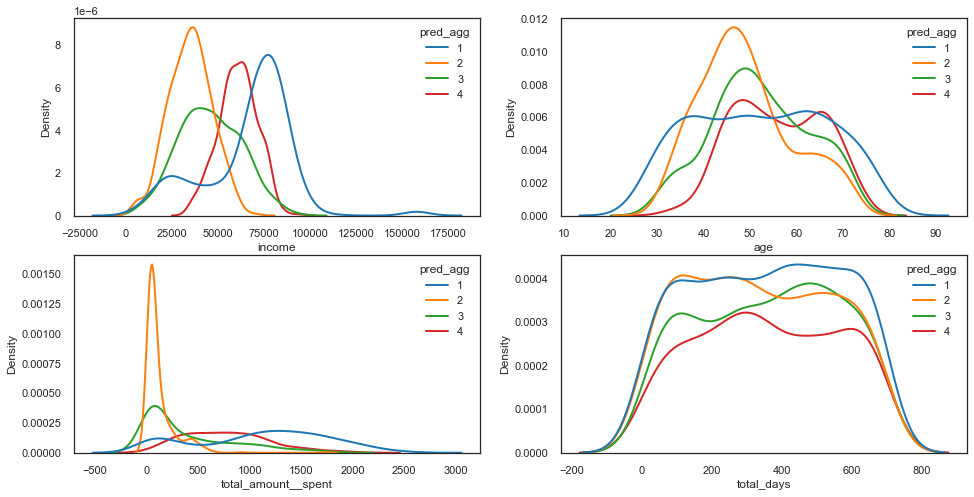

In [74]:
fig,ax = plt.subplots(2,2,figsize=(16,8))
sns.set_theme(style="white")
for variable, subplot in zip(other_feat,ax.flatten()):
  sns.kdeplot(data=msdf,x=variable,hue='pred_agg',ax=subplot,palette='tab10',linewidth=2)

findings in cluter 1:
    
The ratio of married to single is 1:1.5
- over 95% do not have kids
- Family of 1 or 2
- Over 95% of them are not parents
- has the highest income
- age is between 20 and 90
- Highest amount spenders
- most loyal customers

findings in cluster 2: 

over 95% are married
- has atleast 1 or 2 kids
- family of 3 and 4
- definitely a parent
- lowest income
- age is between 25 -80
- lowest spenders
- Have a good engagement with the
firm

Findings in cluster 3:
    
- Majority are single
- most have atleast one child
- family of 2 or 3
- most are parent
- average income of around 50000
- age is around 25-80
- second lowest spenders after
cluster 2
- have a good engagement with the
firm
(these could be customers who
themselves are not married but
they have a kid at home)

findings in cluster 4:
    
Definitely married
- have atleast 1 kid
-family of 3
- they are definitely a parent
- second highest income after cluster 1
- age is between 30 and 80
- are a good spenders
- have a good engagement with the firm